In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# fetch dataset
from ucimlrepo import fetch_ucirepo 
online_retail = fetch_ucirepo(id=352)
online = online_retail['data']['original']
online.head()
# retail_df.to_csv("data/online_retail_uci.csv", index=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
online_retail.keys()


dict_keys(['data', 'metadata', 'variables'])

In [10]:
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

### Calculate RFM values

In [11]:
online = online.assign(TotalSum = np.multiply(online['UnitPrice'] , online['Quantity']))

In [12]:
snapshot_date = pd.to_datetime('2011-12-10 00:00:00')

In [26]:
# Calculate Recency, Frequency and Monetary value for each customer 
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
datamart.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,325,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


In [27]:
# Unskew the data
datamart_log = np.log1p(datamart)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_log.index, columns=datamart_log.columns)

/Users/s0a067b/.local/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


### Run k-means

In [32]:
from sklearn.cluster import KMeans

In [33]:
datamart_normalized = datamart_normalized.assign(MonetaryValue = datamart_normalized['MonetaryValue'].fillna(0))

In [34]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

### Assign labels to raw data

In [36]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          12.3     266.4        6046.3   984
1          65.2      65.6        1048.9  1848
2         173.9      15.2         267.6  1540

### Calculate sum of squared errors


In [37]:
sse = {}

In [39]:
# Fit KMeans and calculate SSE for each k
for k in range(1, 15):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(datamart_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

In [40]:
sse

{1: 13075.000000000002,
 2: 6872.724111931187,
 3: 5332.832148584559,
 4: 4431.486691638723,
 5: 3810.6414249533286,
 6: 3404.4599799756024,
 7: 3103.1081319414398,
 8: 2872.9173368146558,
 9: 2697.3183172393374,
 10: 2590.3679935009513,
 11: 2314.0706988223033,
 12: 2146.8125199547285,
 13: 2077.9672038646277,
 14: 1953.0628432982958}

### Plot sum of squared errors


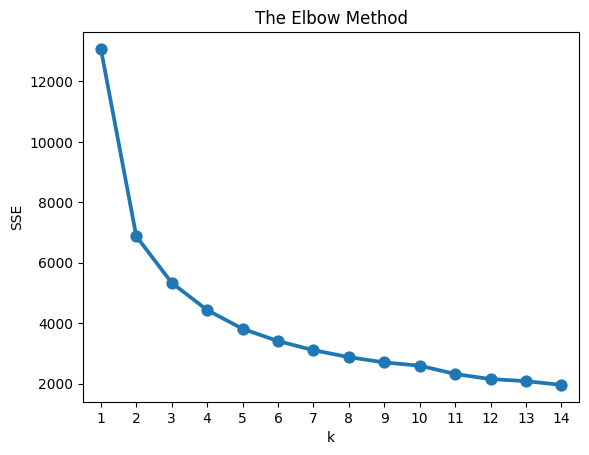

In [47]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Prepare data for the snake plot

In [52]:
datamart_normalized['Cluster'] = cluster_labels

In [53]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(
  					datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value'
					)

In [54]:
datamart_melt

,CustomerID,Cluster,Metric,Value
0,12346.0,2,Recency,1.428946
1,12347.0,0,Recency,-1.889472
2,12348.0,1,Recency,0.398257
3,12349.0,1,Recency,-0.582976
4,12350.0,2,Recency,1.395605
...,...,...,...,...
13111,18280.0,2,MonetaryValue,-1.040967
13112,18281.0,2,MonetaryValue,-1.655896
13113,18282.0,2,MonetaryValue,-1.058146
13114,18283.0,0,MonetaryValue,0.845521


### Visualize snake plot

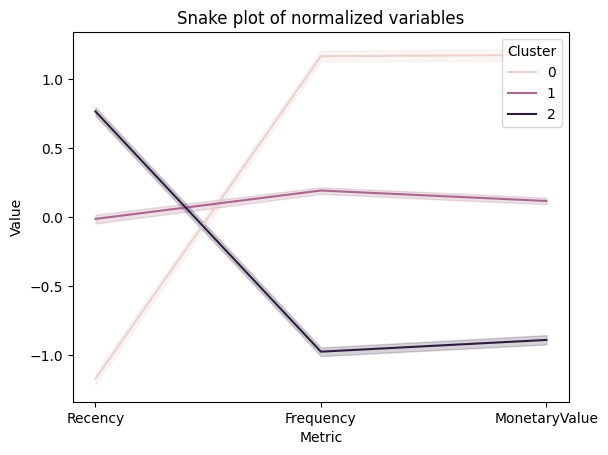

In [55]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot (data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

In [56]:
datamart_melt

,CustomerID,Cluster,Metric,Value
0,12346.0,2,Recency,1.428946
1,12347.0,0,Recency,-1.889472
2,12348.0,1,Recency,0.398257
3,12349.0,1,Recency,-0.582976
4,12350.0,2,Recency,1.395605
...,...,...,...,...
13111,18280.0,2,MonetaryValue,-1.040967
13112,18281.0,2,MonetaryValue,-1.655896
13113,18282.0,2,MonetaryValue,-1.058146
13114,18283.0,0,MonetaryValue,0.845521


### Calculate relative importance of each attribute

In [60]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0          -0.87       1.86           2.18
1          -0.29      -0.30          -0.45
2           0.90      -0.84          -0.86


### Plot relative importance heatmap


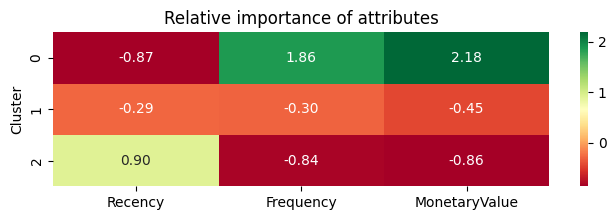

In [61]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

## End-to-end segmentation Project

In [65]:
k = datamart.shape[0]

In [67]:
tenure = np.random.randint(0,365, k)

In [75]:
datamart_rfmt = datamart.assign(Tenure = tenure)

In [89]:
# Import StandardScaler 
from sklearn.preprocessing import StandardScaler

# Apply log transformation
datamart_rfmt_log = np.log1p(datamart_rfmt[datamart_rfmt['MonetaryValue']>=0])

# Initialize StandardScaler and fit it 
scaler = StandardScaler(); scaler.fit(datamart_rfmt_log)

# Transform and store the scaled data as datamart_rfmt_normalized
datamart_rfmt_normalized = scaler.transform(datamart_rfmt_log)

### Calculate and plot sum of squared errors


In [90]:
sse={}

In [91]:
pd.DataFrame(datamart_rfmt_normalized).isnull().sum()

0    0
1    0
2    0
3    0
dtype: int64

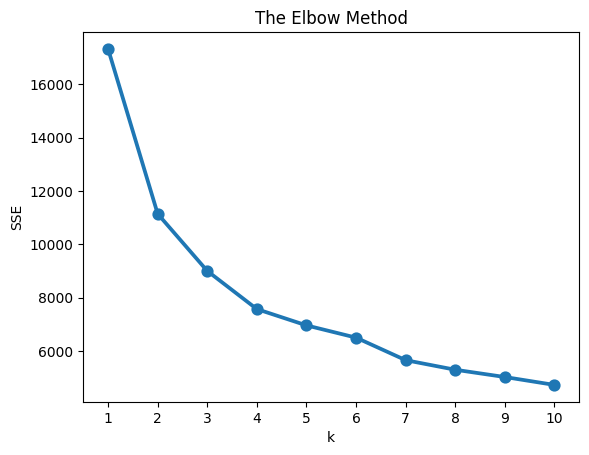

In [92]:
# Fit KMeans and calculate SSE for each k between 1 and 10
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1 ).fit(datamart_rfmt_normalized)

    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_   

# Add the plot title, x and y axis labels
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Build 4 cluster solution

In [93]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_rfmt_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

### Analyse the segments

In [95]:
# Create a new DataFrame by adding a cluster label column to datamart_rfmt
datamart_rfmt_k4 = datamart_rfmt[datamart_rfmt['MonetaryValue']>=0].assign(Cluster=cluster_labels)

# Group by cluster
grouped = datamart_rfmt_k4.groupby(['Cluster'])

# Calculate average RFMT values and segment sizes for each cluster
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Tenure': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0          11.6     276.3        6378.7  191.4   887
1         170.6      15.2         278.9  197.4  1389
2          82.5      71.5        1133.4   23.2   455
3          65.3      67.4        1095.9  212.2  1599